In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

# 1. Preparación de los datos: División en train y test

Del conjunto de datos, nos quedamos solo con la ciudad de "Madrid". Posteriormente dividimos el dataset en conjunto de train y de test.

In [2]:
file_path = './data/airbnb-listings-extract.csv'
df = pd.read_csv(file_path, delimiter=';')

df_madrid = df[df['City'] == 'Madrid']

train, test = train_test_split(df_madrid, test_size=0.2, shuffle=True, random_state=42)

print(f"Dimensiones del conjunto de training: {train.shape}")
print(f"Dimensiones del conjunto de test: {test.shape}")

train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del conjunto de training: (10565, 89)
Dimensiones del conjunto de test: (2642, 89)


Ahora trabajamos solo con el conjunto de train.

In [3]:
df = pd.read_csv('./train.csv', sep=';', decimal='.')

# 2. Análisis exploratorio y Preprocesamiento

He decidido mezclar ambos apartados porque del análisis exploratorio voy a llegar a determinadas conclusiones para ir eliminando variables irrelevantes, o con outliers o con datos nulos mientras avanzo.

## 2.1 Head, info, describe: Una visual a nuestros datos

In [4]:
df.head() # Una primera visual de las primeras 5 filas de mi dataset

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,13270355,https://www.airbnb.com/rooms/13270355,20170407214119,2017-04-08,Madrid Center Sunny Appartment,"Places of interest: CaixaForum Madrid, Barrio ...","Nice appartment in the center of Madrid, with ...","Places of interest: CaixaForum Madrid, Barrio ...",none,NaN,...,10.0,9.0,9.0,NaN,NaN,flexible,2.0,7.63,"40.4110160191,-3.69965649095","Host Has Profile Pic,Host Identity Verified,Re..."
1,8991818,https://www.airbnb.com/rooms/8991818,20170407214119,2017-04-08,ROOMS IN MADRID,ROOMS FOR RENT IN MADRID. FOR ERASMUS STUDENS ...,NaN,ROOMS FOR RENT IN MADRID. FOR ERASMUS STUDENS ...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,NaN,"40.4247850244,-3.65830048851","Host Has Profile Pic,Requires License"
2,5310107,https://www.airbnb.com/rooms/5310107,20170407214119,2017-04-08,Attic with terrace Madrid city center -WIFI- cozy,Attic with a marvellous terrace on top. WIFI V...,Home has been reciently reformed. There plent...,Attic with a marvellous terrace on top. WIFI V...,none,"Right in the city center of Madrid, at Barrio ...",...,10.0,10.0,9.0,NaN,NaN,moderate,2.0,2.28,"40.4151910492,-3.69859147994","Host Has Profile Pic,Host Identity Verified,Is..."
3,16144069,https://www.airbnb.com/rooms/16144069,20170407214119,2017-04-08,1.- Studio Private ÓPERA/SOL. With Balcony,"This cozy studio of 18mts 2, is completely ref...",NaN,"This cozy studio of 18mts 2, is completely ref...",none,Calle muy privilegiada y céntrica (Calle del A...,...,9.0,10.0,9.0,NaN,NaN,moderate,6.0,2.97,"40.4189857656,-3.70727564846","Host Has Profile Pic,Is Location Exact,Require..."
4,13445117,https://www.airbnb.com/rooms/13445117,20170407214119,2017-04-08,Habitación para una persona o dos,Mi alojamiento es bueno para parejas y aventur...,NaN,Mi alojamiento es bueno para parejas y aventur...,none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,1.0,0.10,"40.4058653456,-3.67647489861","Host Has Profile Pic,Host Identity Verified,Is..."


In [5]:
df.info() # Nos da información sobre todas las variables de mi modelo, si contiene nulos y el tipo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10565 entries, 0 to 10564
Data columns (total 89 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10565 non-null  int64  
 1   Listing Url                     10565 non-null  object 
 2   Scrape ID                       10565 non-null  int64  
 3   Last Scraped                    10565 non-null  object 
 4   Name                            10565 non-null  object 
 5   Summary                         10182 non-null  object 
 6   Space                           7717 non-null   object 
 7   Description                     10560 non-null  object 
 8   Experiences Offered             10565 non-null  object 
 9   Neighborhood Overview           6649 non-null   object 
 10  Notes                           3989 non-null   object 
 11  Transit                         6592 non-null   object 
 12  Access                          

In [6]:
df.describe() # Nos ofrece una descripción estadíistica del dataset por cada variable

,ID,Scrape ID,Host ID,Host Response Rate,Host Acceptance Rate,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Jurisdiction Names,Calculated host listings count,Reviews per Month
count,1.056500e+04,1.056500e+04,1.056500e+04,9225.000000,0.0,10563.000000,10563.000000,10565.000000,10565.000000,10565.000000,...,8276.000000,8261.000000,8267.000000,8252.000000,8266.000000,8250.000000,8250.000000,0.0,10565.000000,8378.000000
mean,1.042161e+07,2.017041e+13,3.751608e+07,94.837615,NaN,9.476569,9.476569,40.420679,-3.697294,3.182773,...,91.609836,9.408667,9.321761,9.618396,9.644447,9.543273,9.209818,NaN,7.414671,1.934709
std,5.495137e+06,0.000000e+00,3.437059e+07,15.349749,NaN,26.587255,26.587255,0.020151,0.023352,1.986991,...,8.964766,0.919281,1.002906,0.796256,0.754741,0.764329,0.954905,NaN,18.860692,1.905633
min,1.862800e+04,2.017041e+13,1.745300e+04,0.000000,NaN,0.000000,0.000000,40.332908,-3.835498,1.000000,...,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000,0.020000
25%,5.938004e+06,2.017041e+13,7.657596e+06,100.000000,NaN,1.000000,1.000000,40.410114,-3.707852,2.000000,...,88.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,1.000000,0.480000
50%,1.155134e+07,2.017041e+13,2.761147e+07,100.000000,NaN,2.000000,2.000000,40.418822,-3.701568,2.000000,...,94.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,2.000000,1.280000
75%,1.533683e+07,2.017041e+13,5.761493e+07,100.000000,NaN,5.000000,5.000000,40.427905,-3.693932,4.000000,...,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,4.000000,2.900000
max,1.810984e+07,2.017041e+13,1.247534e+08,100.000000,NaN,265.000000,265.000000,40.514247,-3.573613,16.000000,...,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,145.000000,17.210000


## 2.2 Eliminación de algunas variables  

En df.info() hemos obtenido mucha información de nuestras variables, y nos ha dado una primera impresión de variables que se pueden eliminar de nuestro modelo porque no aportan información valiosa para nuestro análisis.

Estas variables son: 
- Identificadores y URLs: ID, Listing Url, Scrape ID, Host ID ,Host URL, Thumbnail Url, Medium Url, Picture Url, XL Picture Url, Host Thumbnail Url, Host Picture Url
- Fechas de actualizaciones: Last Scraped, Calendar Updated, Calendar last Scraped
- Textos descriptivos: Name, Summary, Space, Description, Neighborhood Overview, Notes, Transit, Access, Interaction, House Rules, Host Name, Host About, Host Neighbourhood, Host Location, Host Verifications, First Review, Last Review
- Variables con muchos nulos que dejan de ser relevantes y no tenemos suficientes datos para imputar: Host Acceptance Rate, Jurisdiction Names, Has Availability, License, Square Feet
- Variables redundantes: Availability 30, Availability 60, Availability 90 (dejamos Availability 365), Weekly Price, Monthly Price (para que no afecten a Price que es nuestra dependiente)
- Variables de ubicación: Street, Geolocation, Smart Location (ya tenemos latitud y longitud), Country (solo vemos Madrid), Zipcode (ya tenemos Neighbourhood), Market, State

In [7]:
columns_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Host ID', 'Host URL', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host Thumbnail Url', 'Host Picture Url', 
    'Last Scraped', 'Calendar Updated', 'Calendar last Scraped', 
    'Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes', 
    'Transit', 'Access', 'Interaction', 'House Rules', 'Host Name', 'Host About', 
    'Host Neighbourhood', 'Host Location', 'Host Verifications', 'First Review', 'Last Review',
    'Host Acceptance Rate', 'Jurisdiction Names', 'Has Availability', 
    'License', 'Square Feet', 'Availability 30', 'Availability 60', 'Availability 90', 
    'Weekly Price', 'Monthly Price', 'Street', 'Geolocation', 'Smart Location', 
    'Country', 'Zipcode', 'Market', 'State'
]

df.drop(columns=columns_to_drop, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10565 entries, 0 to 10564
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiences Offered             10565 non-null  object 
 1   Host Since                      10563 non-null  object 
 2   Host Response Time              9225 non-null   object 
 3   Host Response Rate              9225 non-null   float64
 4   Host Listings Count             10563 non-null  float64
 5   Host Total Listings Count       10563 non-null  float64
 6   Neighbourhood                   6998 non-null   object 
 7   Neighbourhood Cleansed          10565 non-null  object 
 8   Neighbourhood Group Cleansed    10565 non-null  object 
 9   City                            10565 non-null  object 
 10  Country Code                    10565 non-null  object 
 11  Latitude                        10565 non-null  float64
 12  Longitude                       

Nos quedamos de momento con estas variables, pero también considero que las variables Review pueden estar correlacionadas al igual que las variables de "Listing Count", pero prefiero verlo en el siguiente apartado y tratarlas de forma especial.

## 2.3 Correlación 

### Aquí también eliminaremos otras variables y generaremos nuevas a partir de otras variables. 

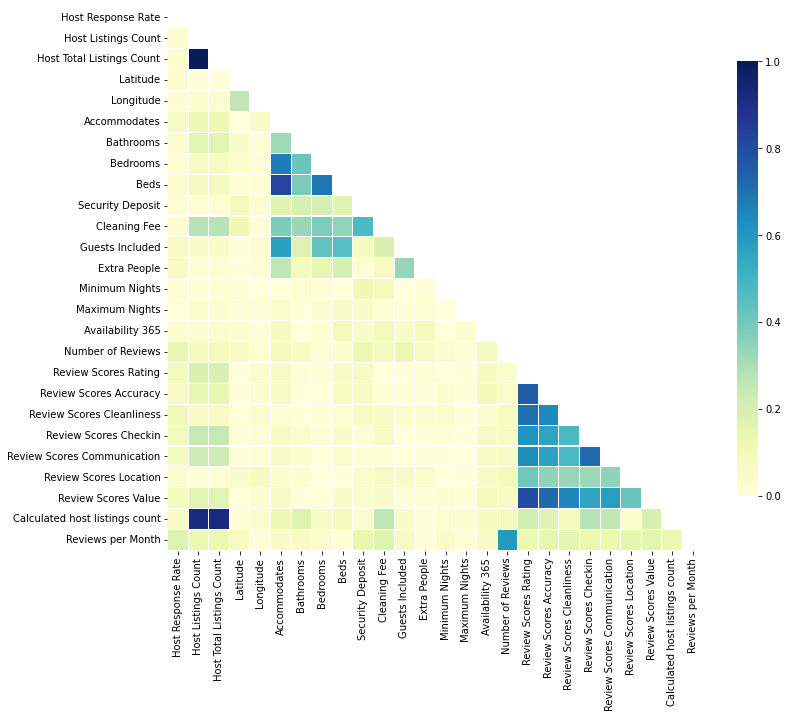

In [8]:
corr = np.abs(df.drop(['Price'], axis=1).corr())

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Un umbral común para detectar la multicolinealidad es 0.8 (en valor absoluto), de acuerdo con autores como:
> Kennedy (2008)

> Pal and Soriya (2012)

Por ello, voy a establecer este umbral para determinar su presencia en mis datos.

In [9]:
threshold = 0.8
high_corr_var = [(corr.columns[i], corr.columns[j])
                 for i in range(len(corr.columns))
                 for j in range(i+1, len(corr.columns))
                 if corr.iloc[i, j] > threshold]

print("Pares de variables con correlación superior a 0.8:")
for var1, var2 in high_corr_var:
    print(f"{var1} - {var2}: {corr.loc[var1, var2]}")

Pares de variables con correlación superior a 0.8:
Host Listings Count - Host Total Listings Count: 1.0
Host Listings Count - Calculated host listings count: 0.9226258620359582
Host Total Listings Count - Calculated host listings count: 0.9226258620359582
Accommodates - Beds: 0.8223118528573612
Review Scores Rating - Review Scores Value: 0.8006164445376684


Las conclusiones que saco son las siguientes:
- Entre Accomodates y Beds, podemos eliminar directamente Accomodates.
- Entre las variables Review hay cierta correlación, pero solo voy a tratar el caso más grave que es entre Review Scores Rating y Review Scores Value, donde voy a hacer una nueva variable con la media de ambas.
- Como veíamos antes, las variables Host Listings Count, Host Total Listings Count y Calculated host listings count, tienen una correlación prácticamente directa, por lo que se puede hacer también una nueva variable con la media de las tres. Considero que esta variable es importante porque el número de propiedades de un anfitrión puede afectar de forma escalada al precio al que pone a sus alojamientos pudiendo llegar a ser incluso más competitivos que un anfitrión que solo tenga una sola propiedad.

In [10]:
df['Host Listings Combined'] = df[['Calculated host listings count', 'Host Total Listings Count', 'Host Listings Count']].mean(axis=1)
df['Review Combined'] = df[['Review Scores Rating', 'Review Scores Value']].mean(axis=1)
df.drop(columns=['Accommodates','Calculated host listings count', 'Host Total Listings Count', 'Host Listings Count', 'Review Scores Rating', 'Review Scores Value'], axis=1, inplace=True)

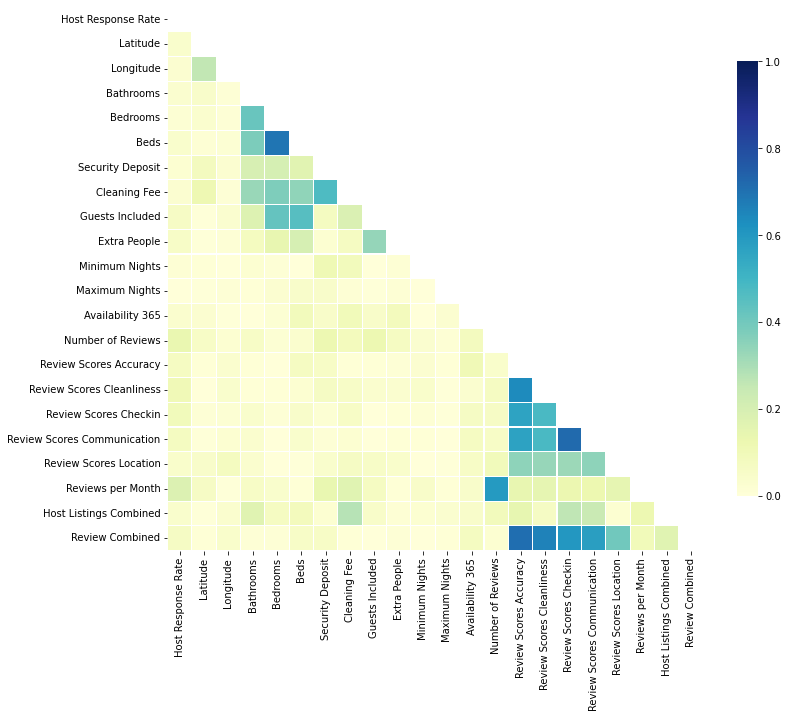

In [11]:
corr = np.abs(df.drop(['Price'], axis=1).corr())

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [12]:
df.head() # Me he quedado con 39 columnas

,Experiences Offered,Host Since,Host Response Time,Host Response Rate,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,Country Code,Latitude,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Cancellation Policy,Reviews per Month,Features,Host Listings Combined,Review Combined
0,none,2016-05-30,within an hour,100.0,NaN,Embajadores,Centro,Madrid,ES,40.411016,...,9.0,8.0,10.0,10.0,9.0,flexible,7.63,"Host Has Profile Pic,Host Identity Verified,Re...",2.000000,48.5
1,none,2015-10-19,NaN,NaN,NaN,Ventas,Ciudad Lineal,Madrid,ES,40.424785,...,NaN,NaN,NaN,NaN,NaN,flexible,NaN,"Host Has Profile Pic,Requires License",1.000000,NaN
2,none,2015-02-10,within an hour,100.0,Cortes,Cortes,Centro,Madrid,ES,40.415191,...,9.0,10.0,10.0,10.0,10.0,moderate,2.28,"Host Has Profile Pic,Host Identity Verified,Is...",2.666667,51.0
3,none,2016-11-27,within an hour,100.0,Sol,Sol,Centro,Madrid,ES,40.418986,...,8.0,8.0,9.0,9.0,10.0,moderate,2.97,"Host Has Profile Pic,Is Location Exact,Require...",6.000000,48.0
4,none,2015-11-20,NaN,NaN,Pacifico,Pacífico,Retiro,Madrid,ES,40.405865,...,NaN,NaN,NaN,NaN,NaN,flexible,0.10,"Host Has Profile Pic,Host Identity Verified,Is...",1.000000,NaN


Comprobamos de nuevo nuestra matriz de correlación para ver que todo va mejorando. Ahora haremos un scatter plot para ver cómo se relacionan todas las variables entre sí.

In [13]:
#pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
#plt.show()

## 2.4 Outliers

Voy a definir una función que identifique los valores atípicos o outliers en variables numéricas usando el rango intercuartílico (IQR) para cada una de ellas. De este modo, veremos de un vistazo, posibles variables a tener en cuenta para eliminar outliers.

In [14]:
# Veo el número de variables numéricas que tengo

num_float64 = df.select_dtypes(include=['float64']).shape[1]
num_int64 = df.select_dtypes(include=['int64']).shape[1]

print(f"Número de columnas tipo float64: {num_float64}")
print(f"Número de columnas tipo int64: {num_int64}")
print(f"Un total de {num_float64+num_int64} variables numéricas")

Número de columnas tipo float64: 17
Número de columnas tipo int64: 6
Un total de 23 variables numéricas


In [15]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Hago la función para IQR

def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers

outliers_summary = {}
for col in numeric_cols:
    outliers = find_outliers_iqr(df[col])
    outliers_summary[col] = outliers.sum()

outliers_summary = pd.DataFrame.from_dict(outliers_summary, orient='index', columns=['Número de outliers según IQR'])
outliers_summary = outliers_summary.sort_values(by='Número de outliers según IQR', ascending=False)
print(outliers_summary)

                             Número de outliers según IQR
Bathrooms                                            2460
Host Response Rate                                   2125
Longitude                                            1624
Host Listings Combined                               1387
Beds                                                 1197
Number of Reviews                                    1042
Latitude                                              980
Guests Included                                       765
Minimum Nights                                        624
Price                                                 520
Review Scores Cleanliness                             379
Cleaning Fee                                          347
Review Combined                                       313
Review Scores Accuracy                                266
Reviews per Month                                     259
Security Deposit                                      258
Bedrooms      

Revisando las variables con posibles outliers, voy a hacer una serie de gráficos de las 5 primeras que más outliers tienen. Pero voy a dejar fuera a Longitude, que es más amplia, y a meter Price, puesto que es mi dependiente y me conviene quitar los outliers. En concreto, haré un histograma, un bloxplot de cada una y un scatter plot con la variable Price. De este modo podré visualizar cuál o cuáles tiene más sentido quitar.

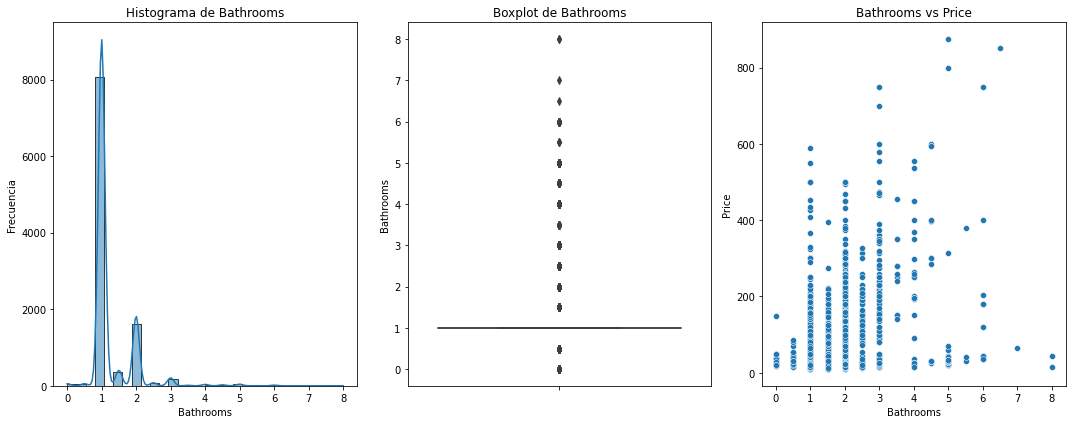

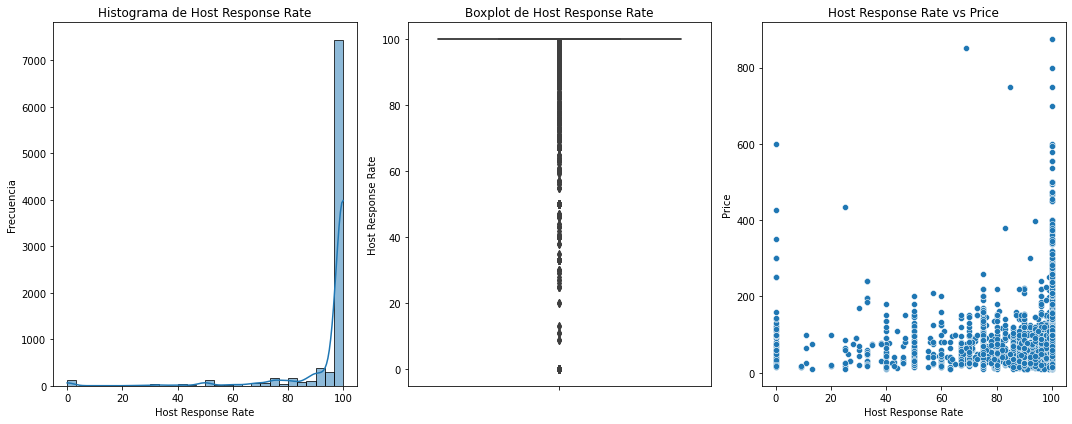

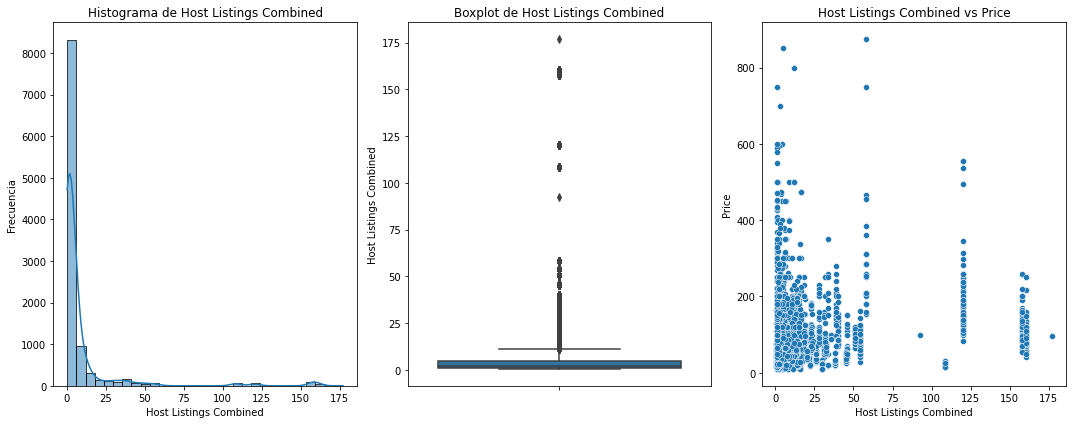

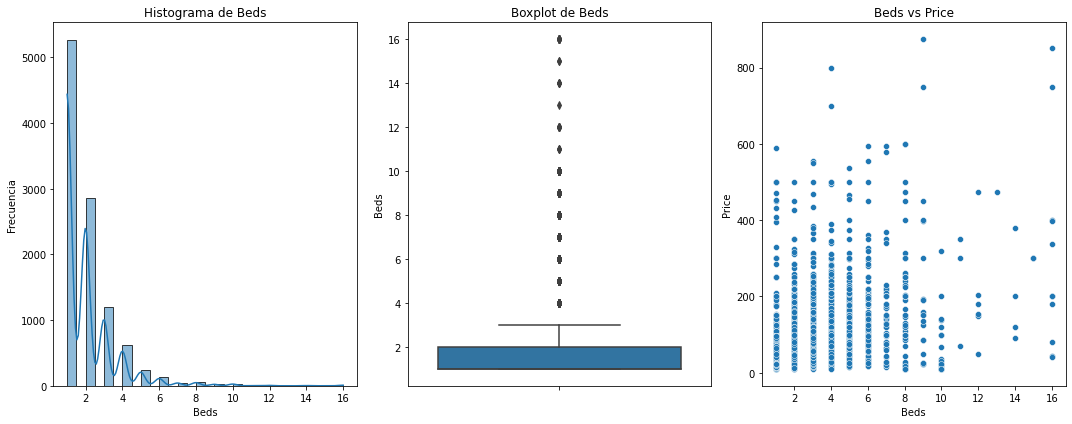

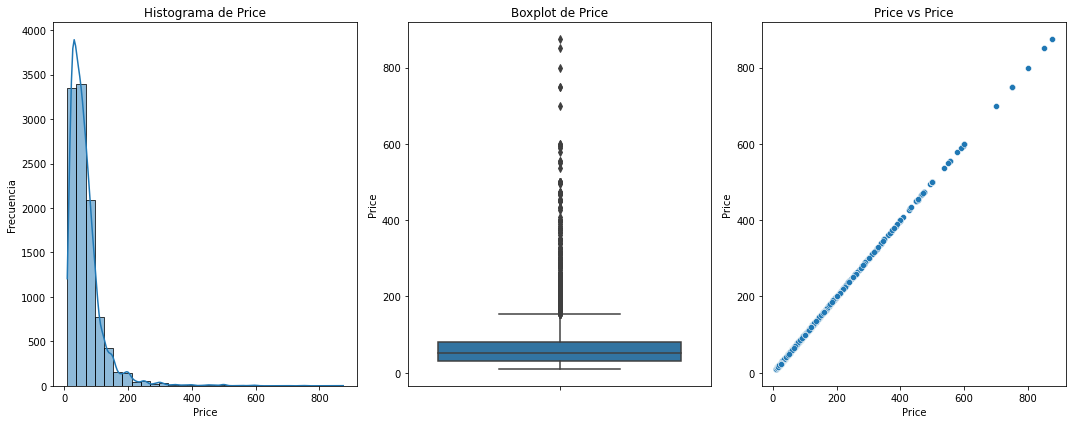

In [16]:
outliers_variables = ['Bathrooms','Host Response Rate','Host Listings Combined','Beds','Price']

for k in outliers_variables:
    plt.figure(figsize=(15, 6))
    
    # Histograma
    plt.subplot(1, 3, 1)
    sns.histplot(df[k], bins=30, kde=True)
    plt.title('Histograma de ' + k)
    plt.xlabel(k)
    plt.ylabel('Frecuencia')

    # Boxplot
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[k])
    plt.title('Boxplot de ' + k)

    # Scatter plot con Price
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=df[k], y=df['Price'])
    plt.title(k + ' vs Price')
    plt.xlabel(k)
    plt.ylabel('Price')

    plt.tight_layout()
    plt.show()

LIMPIEZA --> Antes de seguir con los outliers, he visto que la variable Bathrooms tiene valores medios, como 1.5, 2.5, etc. Creo que esto no se debe dar, por lo que voy a proceder a quitar esos datos, ya que los considero erróneos.

In [17]:
df['Bathrooms'].value_counts()

1.0    8063
2.0    1622
1.5     360
3.0     183
2.5      70
0.0      50
0.5      49
5.0      37
4.0      32
4.5      22
6.0      16
3.5      12
5.5       3
8.0       2
7.0       1
6.5       1
Name: Bathrooms, dtype: int64

In [18]:
df = df[~df['Bathrooms'].isin([0.5,1.5, 2.5,3.5,4.5,5.5,6.5])]

In [19]:
df.shape

(10048, 37)

Siguiendo con los outliers, creo que debemos eliminar outliers de las siguientes variables para quedarnos con los datos que considero más representativos:
- Bathrooms: No tiene sentido propiedades con 0 baños. Haré el corte en menos de 5 baños, inclusive.
- Host Response Rate: Haré el corte en los que tienen más de 60, inclusive.
- Host Listings Combined: Haré el corte en menos de 75 propiedades, no inluído.
- Beds: Haré el corte en menos de 10 camas, inclusive.
- Price: Haré el corte en un mínimo de 400 euros, inclusive.

No obstante, voy a ver el análisis de value_counts de cada una de estas variables para ver si modifico algo.


In [20]:
for k in outliers_variables:
    print(df[k].value_counts())

1.0    8063
2.0    1622
3.0     183
0.0      50
5.0      37
4.0      32
6.0      16
8.0       2
7.0       1
Name: Bathrooms, dtype: int64
100.0    6744
90.0      226
75.0      162
98.0      139
96.0      129
         ... 
41.0        1
42.0        1
59.0        1
26.0        1
28.0        1
Name: Host Response Rate, Length: 66, dtype: int64
1.000000      4387
2.000000      1265
3.000000       668
4.000000       389
1.666667       299
              ... 
22.000000        2
31.333333        2
92.333333        1
177.000000       1
54.333333        1
Name: Host Listings Combined, Length: 81, dtype: int64
1.0     5051
2.0     2736
3.0     1127
4.0      586
5.0      222
6.0      114
8.0       51
7.0       43
10.0      29
9.0       23
16.0       9
12.0       7
11.0       3
14.0       3
13.0       1
Name: Beds, dtype: int64
50.0     477
60.0     421
25.0     392
30.0     381
35.0     345
        ... 
295.0      1
183.0      1
245.0      1
427.0      1
283.0      1
Name: Price, Length: 253, dtyp

In [21]:
# Filtramos el dataframe sin los outliers haciendo uno nuevo.

conditions = (
    (df['Bathrooms'] > 0) &
    (df['Bathrooms'] <= 5) &
    (df['Host Response Rate'] >= 60) &
    (df['Host Listings Combined'] < 75) &
    (df['Beds'] <= 10) &
    (df['Price'] <= 400))

df_no_outliers = df[conditions]

print(f"Tamaño del dataframe original: {df.shape}")
print(f"Tamaño del dataframe sin outliers: {df_no_outliers.shape}")


Tamaño del dataframe original: (10048, 37)
Tamaño del dataframe sin outliers: (8047, 37)


In [22]:
print(
    f'Original: {df.shape[0]} // '
    f'Modificado: {df_no_outliers.shape[0]}\nDiferencia: {df.shape[0] - df_no_outliers.shape[0]}'
)
print(f'Variación: {(((df.shape[0] - df_no_outliers.shape[0])/df.shape[0])*100):.2f}%')

Original: 10048 // Modificado: 8047
Diferencia: 2001
Variación: 19.91%


La verdad es que de este modo me quedo con pocos datos, es una bajada muy importante, por lo que le voy a dar otro enfoque. Me centraré solo en Bathrooms (entre 0 y 5), Beds (menos de 10) y Price (menos de 400), que las considero más relevantes.

In [23]:
# Hacemos de nuevo el dataframe sin los outliers.

conditions = (
    (df['Bathrooms'] > 0) &
    (df['Bathrooms'] <= 5) &
    (df['Beds'] <= 10) &
    (df['Price'] <= 400))


df_no_outliers = df[conditions]

print(f"Tamaño del dataframe original: {df.shape}")
print(f"Tamaño del dataframe sin outliers: {df_no_outliers.shape}")

Tamaño del dataframe original: (10048, 37)
Tamaño del dataframe sin outliers: (9861, 37)


In [24]:
print(
    f'Original: {df.shape[0]} // '
    f'Modificado: {df_no_outliers.shape[0]}\nDiferencia: {df.shape[0] - df_no_outliers.shape[0]}'
)
print(f'Variación: {(((df.shape[0] - df_no_outliers.shape[0])/df.shape[0])*100):.2f}%')

Original: 10048 // Modificado: 9861
Diferencia: 187
Variación: 1.86%


Ahora sí hemos conseguido una variación modesta y con un dataset sin los principales outliers.

In [25]:
df_no_outliers.shape

(9861, 37)

In [26]:
df_no_outliers.describe()

,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Price,Security Deposit,Cleaning Fee,Guests Included,...,Availability 365,Number of Reviews,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Reviews per Month,Host Listings Combined,Review Combined
count,8653.000000,9861.000000,9861.000000,9861.000000,9852.000000,9861.000000,9861.000000,4224.000000,5889.000000,9861.000000,...,9861.000000,9861.000000,7764.000000,7769.000000,7754.000000,7767.000000,7751.000000,7870.000000,9861.000000,7775.000000
mean,94.849994,40.420523,-3.697505,1.218233,1.257410,1.920089,62.915830,180.206439,28.708779,1.555319,...,204.136802,23.263259,9.413833,9.323336,9.619809,9.649929,9.544833,1.962756,8.905689,50.529968
std,15.202810,0.019964,0.022820,0.512754,0.752029,1.327622,44.455591,104.396111,23.415310,1.025391,...,127.226032,38.406878,0.907364,0.998826,0.792815,0.750067,0.764213,1.924768,23.971939,5.302401
min,0.000000,40.332908,-3.822403,1.000000,0.000000,1.000000,9.000000,70.000000,4.000000,1.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.020000,0.333333,11.000000
25%,100.000000,40.410064,-3.707808,1.000000,1.000000,1.000000,32.000000,100.000000,15.000000,1.000000,...,81.000000,1.000000,9.000000,9.000000,9.000000,9.000000,9.000000,0.490000,1.000000,48.500000
50%,100.000000,40.418674,-3.701621,1.000000,1.000000,1.000000,52.000000,150.000000,25.000000,1.000000,...,244.000000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.300000,2.000000,51.500000
75%,100.000000,40.427615,-3.694169,1.000000,1.000000,2.000000,80.000000,200.000000,35.000000,2.000000,...,320.000000,28.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.940000,5.000000,54.000000
max,100.000000,40.514247,-3.573613,5.000000,6.000000,10.000000,400.000000,990.000000,350.000000,16.000000,...,365.000000,446.000000,10.000000,10.000000,10.000000,10.000000,10.000000,17.210000,177.000000,100.000000


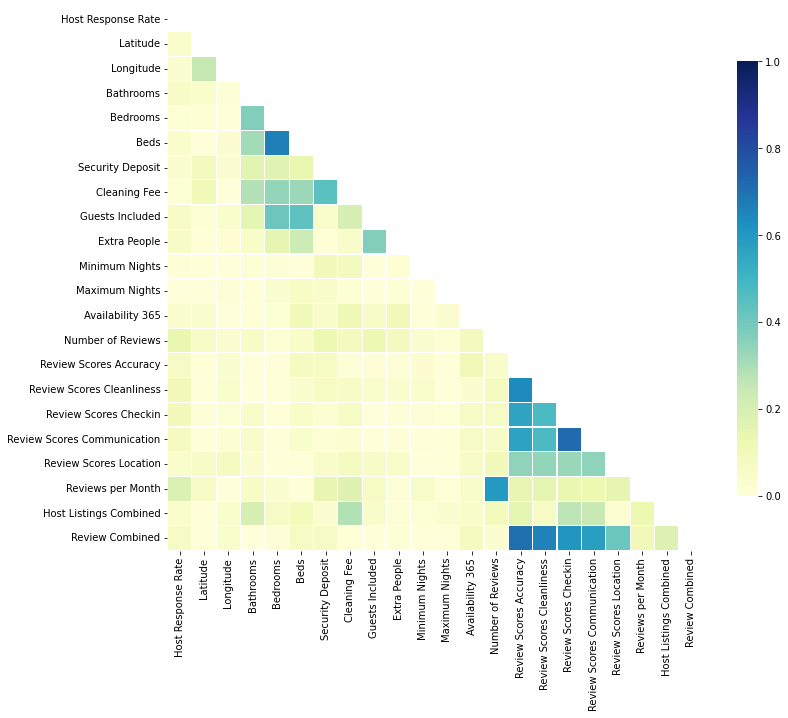

In [27]:
# Voy a ver de nuevo la matriz de correlación para comprobar que todo sigue teniendo sentido

corr = np.abs(df_no_outliers.drop(['Price'], axis=1).corr())

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

## 2.5 Categorización de variables y generación de nuevas características

### Aquí también terminaremos de limpiar el dataset.

Lo primero que haré es sacar el listado de las columnas no numércias, que son éstas.

In [28]:
categoricas = df_no_outliers[list(df_no_outliers.select_dtypes(include=['object']).columns)]
categoricas.head()

,Experiences Offered,Host Since,Host Response Time,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,Country Code,Property Type,Room Type,Bed Type,Amenities,Cancellation Policy,Features
0,none,2016-05-30,within an hour,NaN,Embajadores,Centro,Madrid,ES,Apartment,Entire home/apt,Real Bed,"TV,Cable TV,Wireless Internet,Kitchen,Smoking ...",flexible,"Host Has Profile Pic,Host Identity Verified,Re..."
1,none,2015-10-19,NaN,NaN,Ventas,Ciudad Lineal,Madrid,ES,House,Private room,Real Bed,"TV,Internet,Wireless Internet,Kitchen,Free par...",flexible,"Host Has Profile Pic,Requires License"
2,none,2015-02-10,within an hour,Cortes,Cortes,Centro,Madrid,ES,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",moderate,"Host Has Profile Pic,Host Identity Verified,Is..."
3,none,2016-11-27,within an hour,Sol,Sol,Centro,Madrid,ES,Apartment,Entire home/apt,Real Bed,"TV,Internet,Wireless Internet,Air conditioning...",moderate,"Host Has Profile Pic,Is Location Exact,Require..."
5,none,2016-03-30,a few days or more,NaN,Palos de Moguer,Arganzuela,Madrid,ES,Apartment,Private room,Real Bed,"Wireless Internet,Kitchen,Family/kid friendly,...",flexible,"Host Has Profile Pic,Requires License"


Voy a comprobar los valores únicos de cada una.

In [29]:
categoricas.apply(lambda x: len(x.unique()))

Experiences Offered                1
Host Since                      1967
Host Response Time                 5
Neighbourhood                     66
Neighbourhood Cleansed           124
Neighbourhood Group Cleansed      21
City                               1
Country Code                       1
Property Type                     20
Room Type                          3
Bed Type                           5
Amenities                       8485
Cancellation Policy                5
Features                          60
dtype: int64

Primero me centraré en la categorización de variables, por lo que voy a fijarme en aquellas que tengan pocos valores únicos y a revisar su forma para ver si son ordinales (Label Encoder), ordinales (One-Hot-Encoder) o si hay una alta cardinalidad (Target Encoder). 

En este sentido, me centraré primero en:
- Experiences Offered
- City
- Country Code
- Host Response Time
- Property Type
- Room Type
- Bed Type 
- Cancellation Policy

El resto de variables que tienen más registros únicos, las consideraré para la generación de nuevas características.

Vemos que Experience Offered solo tiene un valor "None", por lo que podemos eliminarla directamente al no aportar información relevante. Lo mismo pasa con City, que solo es Madrid, y con Country Code. Procedemos a eliminarlas directamente.

In [30]:
df_no_outliers.drop(columns=['Experiences Offered', 'City', 'Country Code'], axis=1, inplace=True)

Voy a revisar el resto de variables con value_counts para hacerme una idea de su forma.

In [31]:
df_no_outliers['Host Response Time'].value_counts() # Para ésta usaremos un Label Encoding al ser una variable ordinall

within an hour        5370
within a few hours    1957
within a day          1122
a few days or more     204
Name: Host Response Time, dtype: int64

In [32]:
response_time_order = ['within an hour', 'within a few hours', 'within a day', 'a few days or more']
df_no_outliers['Host Response Time'] = pd.Categorical(df_no_outliers['Host Response Time'], categories=response_time_order, ordered=True)
le_host_response_time = LabelEncoder()
df_no_outliers['Host Response Time'] = le_host_response_time.fit_transform(df_no_outliers['Host Response Time'])

In [33]:
category_counts_property = df_no_outliers['Property Type'].value_counts()
category_counts_property

Apartment             8228
House                  686
Condominium            259
Bed & Breakfast        221
Loft                   191
Other                  157
Guesthouse              34
Dorm                    27
Chalet                  16
Serviced apartment      12
Hostel                  10
Townhouse                5
Boutique hotel           4
Casa particular          3
Earth House              2
Guest suite              2
Camper/RV                1
Timeshare                1
Bungalow                 1
Tent                     1
Name: Property Type, dtype: int64

Hacer One-Hot-Encoding con esta variable añadiría demasiado ruido a mi dataset, y no es lo que queremos, ya que nos generaría 20 variables nuevas. He decidido reducir la dimensionalidad quedándome solo con registros que sean una muestra representativa. He probado con varios parámetros y me voy a quedar con los que sean superiores a 100 registros.

In [34]:
threshold = 100

frequent_categories_property = category_counts_property[category_counts_property > threshold].index.tolist()

df_no_outliers = df_no_outliers[df_no_outliers['Property Type'].isin(frequent_categories_property)]

In [35]:
df_no_outliers['Property Type'].value_counts()

Apartment          8228
House               686
Condominium         259
Bed & Breakfast     221
Loft                191
Other               157
Name: Property Type, dtype: int64

In [36]:
df_no_outliers = pd.get_dummies(df_no_outliers, columns=['Property Type'], prefix='PropertyType')
df_no_outliers.head()

,Host Since,Host Response Time,Host Response Rate,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Latitude,Longitude,Room Type,Bathrooms,...,Reviews per Month,Features,Host Listings Combined,Review Combined,PropertyType_Apartment,PropertyType_Bed & Breakfast,PropertyType_Condominium,PropertyType_House,PropertyType_Loft,PropertyType_Other
0,2016-05-30,3,100.0,NaN,Embajadores,Centro,40.411016,-3.699656,Entire home/apt,1.0,...,7.63,"Host Has Profile Pic,Host Identity Verified,Re...",2.000000,48.5,1,0,0,0,0,0
1,2015-10-19,4,NaN,NaN,Ventas,Ciudad Lineal,40.424785,-3.658300,Private room,1.0,...,NaN,"Host Has Profile Pic,Requires License",1.000000,NaN,0,0,0,1,0,0
2,2015-02-10,3,100.0,Cortes,Cortes,Centro,40.415191,-3.698591,Entire home/apt,1.0,...,2.28,"Host Has Profile Pic,Host Identity Verified,Is...",2.666667,51.0,1,0,0,0,0,0
3,2016-11-27,3,100.0,Sol,Sol,Centro,40.418986,-3.707276,Entire home/apt,1.0,...,2.97,"Host Has Profile Pic,Is Location Exact,Require...",6.000000,48.0,1,0,0,0,0,0
5,2016-03-30,0,25.0,NaN,Palos de Moguer,Arganzuela,40.401892,-3.698068,Private room,1.0,...,NaN,"Host Has Profile Pic,Requires License",2.333333,NaN,1,0,0,0,0,0


In [37]:
df_no_outliers['Room Type'].value_counts()

Entire home/apt    5971
Private room       3654
Shared room         117
Name: Room Type, dtype: int64

In [38]:
df_no_outliers = pd.get_dummies(df_no_outliers, columns=['Room Type'], prefix='RoomType') # One-Hot-Encoding
df_no_outliers.head()

,Host Since,Host Response Time,Host Response Rate,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Latitude,Longitude,Bathrooms,Bedrooms,...,Review Combined,PropertyType_Apartment,PropertyType_Bed & Breakfast,PropertyType_Condominium,PropertyType_House,PropertyType_Loft,PropertyType_Other,RoomType_Entire home/apt,RoomType_Private room,RoomType_Shared room
0,2016-05-30,3,100.0,NaN,Embajadores,Centro,40.411016,-3.699656,1.0,1.0,...,48.5,1,0,0,0,0,0,1,0,0
1,2015-10-19,4,NaN,NaN,Ventas,Ciudad Lineal,40.424785,-3.658300,1.0,1.0,...,NaN,0,0,0,1,0,0,0,1,0
2,2015-02-10,3,100.0,Cortes,Cortes,Centro,40.415191,-3.698591,1.0,2.0,...,51.0,1,0,0,0,0,0,1,0,0
3,2016-11-27,3,100.0,Sol,Sol,Centro,40.418986,-3.707276,1.0,0.0,...,48.0,1,0,0,0,0,0,1,0,0
5,2016-03-30,0,25.0,NaN,Palos de Moguer,Arganzuela,40.401892,-3.698068,1.0,1.0,...,NaN,1,0,0,0,0,0,0,1,0


In [39]:
category_counts_bed = df_no_outliers['Bed Type'].value_counts()
category_counts_bed

Real Bed         9515
Pull-out Sofa     186
Futon              24
Couch              12
Airbed              5
Name: Bed Type, dtype: int64

Considero igual que en Property Type; no tiene sentido quedarme con tan pocos registros, que no son representativos, por lo que voy a quedarme con los varlores por encima de 100.

In [40]:
threshold = 100

frequent_categories_bed = category_counts_bed[category_counts_bed > threshold].index.tolist()

df_no_outliers = df_no_outliers[df_no_outliers['Bed Type'].isin(frequent_categories_bed)]

In [41]:
df_no_outliers = pd.get_dummies(df_no_outliers, columns=['Bed Type'], prefix='BedType')
df_no_outliers.head()

,Host Since,Host Response Time,Host Response Rate,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Latitude,Longitude,Bathrooms,Bedrooms,...,PropertyType_Bed & Breakfast,PropertyType_Condominium,PropertyType_House,PropertyType_Loft,PropertyType_Other,RoomType_Entire home/apt,RoomType_Private room,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed
0,2016-05-30,3,100.0,NaN,Embajadores,Centro,40.411016,-3.699656,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1
1,2015-10-19,4,NaN,NaN,Ventas,Ciudad Lineal,40.424785,-3.658300,1.0,1.0,...,0,0,1,0,0,0,1,0,0,1
2,2015-02-10,3,100.0,Cortes,Cortes,Centro,40.415191,-3.698591,1.0,2.0,...,0,0,0,0,0,1,0,0,0,1
3,2016-11-27,3,100.0,Sol,Sol,Centro,40.418986,-3.707276,1.0,0.0,...,0,0,0,0,0,1,0,0,0,1
5,2016-03-30,0,25.0,NaN,Palos de Moguer,Arganzuela,40.401892,-3.698068,1.0,1.0,...,0,0,0,0,0,0,1,0,0,1


In [42]:
category_counts_cp = df_no_outliers['Cancellation Policy'].value_counts()
category_counts_cp

strict             3644
flexible           3107
moderate           2946
super_strict_30       2
super_strict_60       2
Name: Cancellation Policy, dtype: int64

Voy a eliminar las filas que contienen solo dos registros. Pondré el mismo nivel, me quedo con lo que esté superior a 100.

In [43]:
threshold = 100

frequent_categories_cp = category_counts_cp[category_counts_cp > threshold].index.tolist()

df_no_outliers = df_no_outliers[df_no_outliers['Cancellation Policy'].isin(frequent_categories_cp)]

In [44]:
df_no_outliers = pd.get_dummies(df_no_outliers, columns=['Cancellation Policy'], prefix='CancPolicy')
df_no_outliers.head()

,Host Since,Host Response Time,Host Response Rate,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,Latitude,Longitude,Bathrooms,Bedrooms,...,PropertyType_Loft,PropertyType_Other,RoomType_Entire home/apt,RoomType_Private room,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict
0,2016-05-30,3,100.0,NaN,Embajadores,Centro,40.411016,-3.699656,1.0,1.0,...,0,0,1,0,0,0,1,1,0,0
1,2015-10-19,4,NaN,NaN,Ventas,Ciudad Lineal,40.424785,-3.658300,1.0,1.0,...,0,0,0,1,0,0,1,1,0,0
2,2015-02-10,3,100.0,Cortes,Cortes,Centro,40.415191,-3.698591,1.0,2.0,...,0,0,1,0,0,0,1,0,1,0
3,2016-11-27,3,100.0,Sol,Sol,Centro,40.418986,-3.707276,1.0,0.0,...,0,0,1,0,0,0,1,0,1,0
5,2016-03-30,0,25.0,NaN,Palos de Moguer,Arganzuela,40.401892,-3.698068,1.0,1.0,...,0,0,0,1,0,0,1,1,0,0


Ahora me centraré en el resto de variables para ver cómo puedo tratarlas:
- Neighbourhood, Neighbourhood Cleansed, Neighbourhood Group Cleansed 
- Host Since
- Amenities
- Features

In [45]:
# Primero voy a ver las 3 variables de Neighbouhood a ver si comparten características

df_neighbourhood = df_no_outliers[['Neighbourhood','Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_neighbourhood.head(15)


,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed
0,NaN,Embajadores,Centro
1,NaN,Ventas,Ciudad Lineal
2,Cortes,Cortes,Centro
3,Sol,Sol,Centro
5,NaN,Palos de Moguer,Arganzuela
6,La Latina,Embajadores,Centro
7,NaN,Embajadores,Centro
8,Trafalgar,Trafalgar,Chamberí
9,Berruguete,Berruguete,Tetuán
10,Sol,Sol,Centro


In [46]:
len(df_neighbourhood) - df_neighbourhood.count() # Comprobamos los valores NaN de cada columna

Neighbourhood                   3285
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
dtype: int64

Viendo estos valores, podemos combinar las tres variables para quedarnos con una sola combinada.

In [47]:
df_no_outliers['Combined_Neighbourhood'] = df_no_outliers['Neighbourhood'].combine_first(df_no_outliers['Neighbourhood Cleansed']).combine_first(df_no_outliers['Neighbourhood Group Cleansed'])
df_no_outliers.drop(columns=['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed'], axis=1, inplace=True)

df_no_outliers.head()

,Host Since,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,...,PropertyType_Other,RoomType_Entire home/apt,RoomType_Private room,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood
0,2016-05-30,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,"TV,Cable TV,Wireless Internet,Kitchen,Smoking ...",55.0,...,0,1,0,0,0,1,1,0,0,Embajadores
1,2015-10-19,4,NaN,40.424785,-3.658300,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Kitchen,Free par...",21.0,...,0,0,1,0,0,1,1,0,0,Ventas
2,2015-02-10,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,"TV,Internet,Wireless Internet,Air conditioning...",110.0,...,0,1,0,0,0,1,0,1,0,Cortes
3,2016-11-27,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,"TV,Internet,Wireless Internet,Air conditioning...",39.0,...,0,1,0,0,0,1,0,1,0,Sol
5,2016-03-30,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,"Wireless Internet,Kitchen,Family/kid friendly,...",65.0,...,0,0,1,0,0,1,1,0,0,Palos de Moguer


Al tener múltiples categorías, haré un Target Encoding con la media del precio (Price), que es nuestra variable dependiente, para la nueva columna combinada y eliminaré dicha columna.

In [48]:
mean_encoded = df_no_outliers.groupby('Combined_Neighbourhood')['Price'].mean()

df_no_outliers['Combined_Neighbourhood_Encoded'] = df_no_outliers['Combined_Neighbourhood'].map(mean_encoded)
df_no_outliers.drop(columns=['Combined_Neighbourhood'], axis=1, inplace=True)
df_no_outliers.head()

,Host Since,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,...,PropertyType_Other,RoomType_Entire home/apt,RoomType_Private room,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded
0,2016-05-30,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,"TV,Cable TV,Wireless Internet,Kitchen,Smoking ...",55.0,...,0,1,0,0,0,1,1,0,0,57.456349
1,2015-10-19,4,NaN,40.424785,-3.658300,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Kitchen,Free par...",21.0,...,0,0,1,0,0,1,1,0,0,29.612903
2,2015-02-10,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,"TV,Internet,Wireless Internet,Air conditioning...",110.0,...,0,1,0,0,0,1,0,1,0,75.260563
3,2016-11-27,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,"TV,Internet,Wireless Internet,Air conditioning...",39.0,...,0,1,0,0,0,1,0,1,0,84.435574
5,2016-03-30,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,"Wireless Internet,Kitchen,Family/kid friendly,...",65.0,...,0,0,1,0,0,1,1,0,0,48.513889


Con la antigüedad del dueño podemos generar nuevas características a partir de Host Since, como el año, el mes y los días que lleva el anfitrión en la plataforma.

In [49]:
df_no_outliers['Host Since'].value_counts() 

2014-09-19    99
2014-05-08    79
2016-01-12    60
2017-02-23    57
2015-04-07    53
              ..
2011-02-18     1
2014-03-05     1
2012-07-15     1
2013-05-19     1
2013-03-30     1
Name: Host Since, Length: 1959, dtype: int64

In [50]:
df_no_outliers['Host Since'] = pd.to_datetime(df_no_outliers['Host Since'])

df_no_outliers['Host Since Year'] = df_no_outliers['Host Since'].dt.year
df_no_outliers['Host Since Month'] = df_no_outliers['Host Since'].dt.month

today = pd.to_datetime(datetime.today().strftime('%Y-%m-%d'))
df_no_outliers['Days Since Host'] = (today - df_no_outliers['Host Since']).dt.days
df_no_outliers.drop(columns=['Host Since'], axis=1, inplace=True)


In [51]:
df_no_outliers.head()

,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
0,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,"TV,Cable TV,Wireless Internet,Kitchen,Smoking ...",55.0,NaN,...,0,0,1,1,0,0,57.456349,2016.0,5.0,2911.0
1,4,NaN,40.424785,-3.658300,1.0,1.0,1.0,"TV,Internet,Wireless Internet,Kitchen,Free par...",21.0,NaN,...,0,0,1,1,0,0,29.612903,2015.0,10.0,3135.0
2,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,"TV,Internet,Wireless Internet,Air conditioning...",110.0,175.0,...,0,0,1,0,1,0,75.260563,2015.0,2.0,3386.0
3,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,"TV,Internet,Wireless Internet,Air conditioning...",39.0,NaN,...,0,0,1,0,1,0,84.435574,2016.0,11.0,2730.0
5,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,"Wireless Internet,Kitchen,Family/kid friendly,...",65.0,NaN,...,0,0,1,1,0,0,48.513889,2016.0,3.0,2972.0


In [52]:
df_no_outliers['Amenities'].value_counts() 

TV,Internet,Wireless Internet,Air conditioning,Kitchen,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Essentials,Hangers,Hair dryer,Iron,Laptop friendly workspace                                                                                          32
TV,Wireless Internet,Air conditioning,Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Dryer,Essentials,Shampoo,Hangers,Hair dryer,Iron                                                                                                                                        29
translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50                                                                                                                                                                                                         24
TV,Internet,Wireless Internet,Air conditioning,Kitchen,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Wash

Esta variable tiene múltiples comidades dentro de los alojamientos, pero están separados por comas. Podemos dividirlos por esas características y hacer un recuento de cada una de ellas en cada fila.

In [53]:
df_no_outliers['Amenities'] = df_no_outliers['Amenities'].fillna('') # Rellenamos con huecos vacíos los NaN, significa que no hay ninguna comodidad en el alojamiento
df_no_outliers['Amenities'] = df_no_outliers['Amenities'].apply(lambda x: x.split(','))
df_no_outliers['Amenities'] = df_no_outliers['Amenities'].apply(len) 
df_no_outliers.head()

,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
0,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,18,55.0,NaN,...,0,0,1,1,0,0,57.456349,2016.0,5.0,2911.0
1,4,NaN,40.424785,-3.658300,1.0,1.0,1.0,12,21.0,NaN,...,0,0,1,1,0,0,29.612903,2015.0,10.0,3135.0
2,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,18,110.0,175.0,...,0,0,1,0,1,0,75.260563,2015.0,2.0,3386.0
3,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,13,39.0,NaN,...,0,0,1,0,1,0,84.435574,2016.0,11.0,2730.0
5,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,8,65.0,NaN,...,0,0,1,1,0,0,48.513889,2016.0,3.0,2972.0


In [54]:
df_no_outliers['Features'].value_counts() 

Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License                                                                                                      1711
Host Has Profile Pic,Is Location Exact,Requires License                                                                                                                             1465
Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Instant Bookable                                                                                     1216
Host Has Profile Pic,Host Identity Verified,Requires License                                                                                                                        1007
Host Has Profile Pic,Requires License                                                                                                                                                986
Host Has Profile Pic,Is Location Exact,Requires License,Instant Bookable   

Esta última variable Features la voy a tratar del mismo modo que la anterior.

In [55]:
df_no_outliers['Features'] = df_no_outliers['Features'].fillna('') 
df_no_outliers['Features'] = df_no_outliers['Features'].apply(lambda x: x.split(','))
df_no_outliers['Features'] = df_no_outliers['Features'].apply(len)
df_no_outliers.head()

,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
0,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,18,55.0,NaN,...,0,0,1,1,0,0,57.456349,2016.0,5.0,2911.0
1,4,NaN,40.424785,-3.658300,1.0,1.0,1.0,12,21.0,NaN,...,0,0,1,1,0,0,29.612903,2015.0,10.0,3135.0
2,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,18,110.0,175.0,...,0,0,1,0,1,0,75.260563,2015.0,2.0,3386.0
3,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,13,39.0,NaN,...,0,0,1,0,1,0,84.435574,2016.0,11.0,2730.0
5,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,8,65.0,NaN,...,0,0,1,1,0,0,48.513889,2016.0,3.0,2972.0


### Termino de limpiar el dataset rellenando los datos NaN.

In [56]:
# Contamos los datos NaN de cada variable

nan_counts = df_no_outliers.isnull().sum()
nan_counts

Host Response Time                   0
Host Response Rate                1185
Latitude                             0
Longitude                            0
Bathrooms                            0
Bedrooms                             9
Beds                                 0
Amenities                            0
Price                                0
Security Deposit                  5510
Cleaning Fee                      3851
Guests Included                      0
Extra People                         0
Minimum Nights                       0
Maximum Nights                       0
Availability 365                     0
Number of Reviews                    0
Review Scores Accuracy            2051
Review Scores Cleanliness         2046
Review Scores Checkin             2061
Review Scores Communication       2048
Review Scores Location            2064
Reviews per Month                 1948
Features                             0
Host Listings Combined               0
Review Combined          

Lo primero que veo es que puedo eliminar directamente los que vienen de Host Since y Bedrooms, porque solo son dos y 9 filas, respectivamente.

In [57]:
df_no_outliers.dropna(subset=['Host Since Year','Host Since Month', 'Days Since Host', 'Bedrooms'], inplace=True)

Ahora voy a trabajar con Host Response Rate, Security Deposit, y Cleaning Fee. Voy a ver sus distribuciones para ver cuál es la mejor forma de rellenar sus NaN.

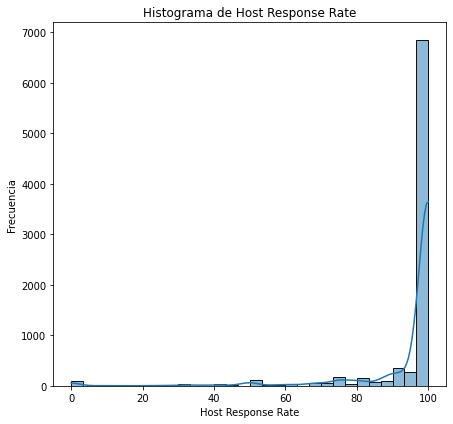

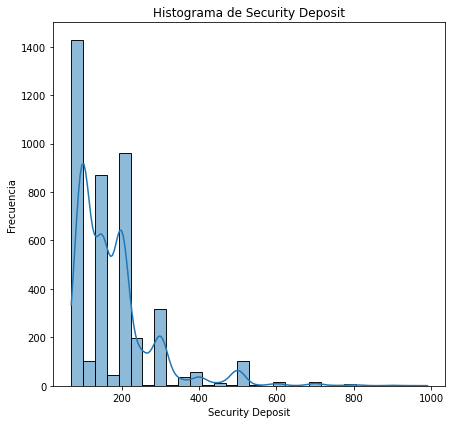

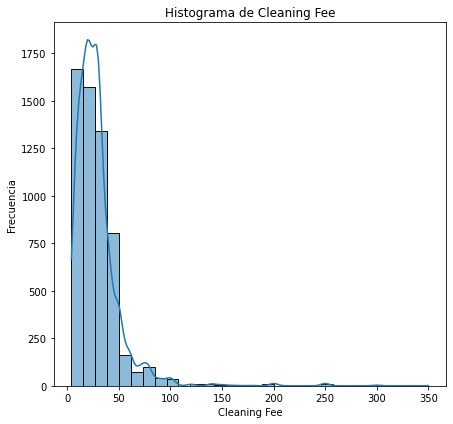

In [58]:
def plot_distribution(df, column_name):
    plt.figure(figsize=(12, 6))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(df[column_name], kde=True, bins=30)
    plt.title(f'Histograma de {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

plot_distribution(df_no_outliers, 'Host Response Rate')
plot_distribution(df_no_outliers, 'Security Deposit')
plot_distribution(df_no_outliers, 'Cleaning Fee')


No tienen distribuciones normales, por lo que, rellenar con su media puede no ser la mejor opción. Voy a optar por rellenarlos con la mediana, puesto que es menos sensible a valores atípicos.

In [59]:
def fill_na_with_median(df, column_name):
    median_value = df[column_name].median()
    df[column_name].fillna(median_value, inplace=True)
    
    return df

columns_to_fill = ['Host Response Rate', 'Security Deposit', 'Cleaning Fee']
for column in columns_to_fill:
    df_no_outliers = fill_na_with_median(df_no_outliers, column)
    
df_no_outliers.head()

,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
0,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,18,55.0,150.0,...,0,0,1,1,0,0,57.456349,2016.0,5.0,2911.0
1,4,100.0,40.424785,-3.658300,1.0,1.0,1.0,12,21.0,150.0,...,0,0,1,1,0,0,29.612903,2015.0,10.0,3135.0
2,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,18,110.0,175.0,...,0,0,1,0,1,0,75.260563,2015.0,2.0,3386.0
3,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,13,39.0,150.0,...,0,0,1,0,1,0,84.435574,2016.0,11.0,2730.0
5,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,8,65.0,150.0,...,0,0,1,1,0,0,48.513889,2016.0,3.0,2972.0


Finalmente, veré las variables Review para terminar de rellenar sus datos.
Dado que estas variables tienen relación entre sí, he pensado buscar otro método más sofisticado para rellenar sus NaN y preservar esta relación entre ellas.

En concreto, voy a usar el método MICE (Multiple Imputation by Chained Equations) para rellenar estas variables con datos faltantes. MICE utiliza un enfoque iterativo y probabilístico para generar múltiples valores imputados para cada dato faltante, considerando las relaciones entre las variables, por lo que creo que puede ser ideal para este conjunto de Reviews.
Funciona de la siguiente manera:

Para cada variable con valores faltantes, MICE ajusta un modelo de predicción utilizando las otras variables como predictores y utiliza el modelo ajustado para imputar los valores faltantes en la variable actual.
Este proceso se repite para cada variable con valores faltantes en el conjunto de datos.
Se realizan múltiples iteraciones (cadenas) hasta que las imputaciones convergen y se estabilizan, proporcionando estimaciones más precisas.

In [60]:
columns_to_fill_with_mice = ['Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin',
                             'Review Scores Communication', 'Review Scores Location', 'Reviews per Month', 'Review Combined']

imputer = IterativeImputer(random_state=42)
df_mice_part = df_no_outliers[columns_to_fill_with_mice]
df_mice_imputed = pd.DataFrame(imputer.fit_transform(df_mice_part), columns=df_mice_part.columns, index=df_mice_part.index)

df_no_outliers.update(df_mice_imputed)
df_no_outliers.head()

,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
0,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,18,55.0,150.0,...,0,0,1,1,0,0,57.456349,2016.0,5.0,2911.0
1,4,100.0,40.424785,-3.658300,1.0,1.0,1.0,12,21.0,150.0,...,0,0,1,1,0,0,29.612903,2015.0,10.0,3135.0
2,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,18,110.0,175.0,...,0,0,1,0,1,0,75.260563,2015.0,2.0,3386.0
3,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,13,39.0,150.0,...,0,0,1,0,1,0,84.435574,2016.0,11.0,2730.0
5,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,8,65.0,150.0,...,0,0,1,1,0,0,48.513889,2016.0,3.0,2972.0


In [61]:
# Compruebo que todas las variables son numéricas y que verdaderamente no contienen nulos para avanzar

df_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9686 entries, 0 to 10564
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Response Time              9686 non-null   int64  
 1   Host Response Rate              9686 non-null   float64
 2   Latitude                        9686 non-null   float64
 3   Longitude                       9686 non-null   float64
 4   Bathrooms                       9686 non-null   float64
 5   Bedrooms                        9686 non-null   float64
 6   Beds                            9686 non-null   float64
 7   Amenities                       9686 non-null   int64  
 8   Price                           9686 non-null   float64
 9   Security Deposit                9686 non-null   float64
 10  Cleaning Fee                    9686 non-null   float64
 11  Guests Included                 9686 non-null   int64  
 12  Extra People                    9

In [62]:
# También voy a repetir el describe para volver a hacer una visual de mis datos y que no haya nada "raro"

df_no_outliers.describe()

,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Price,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
count,9686.00000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,...,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000,9686.000000
mean,2.63535,95.486579,40.420444,-3.697516,1.218253,1.261305,1.920401,14.346996,63.190791,163.130188,...,0.011666,0.019100,0.980900,0.320359,0.303944,0.375697,63.181002,2014.325315,6.282883,3497.902953
std,0.90920,14.340003,0.019844,0.022654,0.511369,0.754791,1.316337,4.631052,44.571018,70.114074,...,0.107384,0.136883,0.136883,0.466639,0.459982,0.484327,16.387419,1.617915,3.327471,581.614389
min,0.00000,0.000000,40.332908,-3.822403,1.000000,0.000000,1.000000,1.000000,9.000000,70.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,2009.000000,1.000000,2599.000000
25%,2.00000,100.000000,40.410064,-3.707764,1.000000,1.000000,1.000000,11.000000,32.000000,150.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,53.335766,2013.000000,3.000000,3025.000000
50%,3.00000,100.000000,40.418662,-3.701606,1.000000,1.000000,1.000000,14.000000,53.000000,150.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,67.573333,2015.000000,6.000000,3377.000000
75%,3.00000,100.000000,40.427578,-3.694128,1.000000,1.000000,2.000000,17.000000,80.000000,150.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,75.115646,2016.000000,9.000000,3943.000000
max,4.00000,100.000000,40.514247,-3.573613,5.000000,6.000000,10.000000,34.000000,400.000000,990.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,110.144068,2017.000000,12.000000,5481.000000


Genial. Ya podemos pasar a la parte de modelado, donde tomaremos Price como variable dependiente. Para ello, la pasaremos a la primera columna de nuestro dataset.

In [63]:
df_no_outliers = df_no_outliers[['Price'] + [col for col in df_no_outliers.columns if col != 'Price']]
df_no_outliers.head()

,Price,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
0,55.0,3,100.0,40.411016,-3.699656,1.0,1.0,1.0,18,150.0,...,0,0,1,1,0,0,57.456349,2016.0,5.0,2911.0
1,21.0,4,100.0,40.424785,-3.658300,1.0,1.0,1.0,12,150.0,...,0,0,1,1,0,0,29.612903,2015.0,10.0,3135.0
2,110.0,3,100.0,40.415191,-3.698591,1.0,2.0,4.0,18,175.0,...,0,0,1,0,1,0,75.260563,2015.0,2.0,3386.0
3,39.0,3,100.0,40.418986,-3.707276,1.0,0.0,1.0,13,150.0,...,0,0,1,0,1,0,84.435574,2016.0,11.0,2730.0
5,65.0,0,25.0,40.401892,-3.698068,1.0,1.0,1.0,8,150.0,...,0,0,1,1,0,0,48.513889,2016.0,3.0,2972.0


# 3. Modelado

## 3.1 Preparamos los datos de train y test para el modelado

In [64]:
# Preparamos los datos de train

data = df_no_outliers.values

y_train = data[:,0:1] # Price como dependiente
X_train = data[:,1:]      

feature_names = df_no_outliers.columns[1:]

scaler = preprocessing.StandardScaler().fit(X_train) # Escalamos los datos
X_train_scaled = scaler.transform(X_train)

In [65]:
# Ponemos todo el preprocesamiento en una sola celda para ejecutarla en test

df_test = pd.read_csv('./test.csv', sep=';', decimal='.')
columns_to_drop = [
    'ID', 'Listing Url', 'Scrape ID', 'Host ID', 'Host URL', 'Thumbnail Url', 'Medium Url', 
    'Picture Url', 'XL Picture Url', 'Host Thumbnail Url', 'Host Picture Url', 
    'Last Scraped', 'Calendar Updated', 'Calendar last Scraped', 
    'Name', 'Summary', 'Space', 'Description', 'Neighborhood Overview', 'Notes', 
    'Transit', 'Access', 'Interaction', 'House Rules', 'Host Name', 'Host About', 
    'Host Neighbourhood', 'Host Location', 'Host Verifications', 'First Review', 'Last Review',
    'Host Acceptance Rate', 'Jurisdiction Names', 'Has Availability', 
    'License', 'Square Feet', 'Availability 30', 'Availability 60', 'Availability 90', 
    'Weekly Price', 'Monthly Price', 'Street', 'Geolocation', 'Smart Location', 
    'Country', 'Zipcode', 'Market', 'State'
]

df_test.drop(columns=columns_to_drop, axis=1, inplace=True)

df_test['Host Listings Combined'] = df_test[['Calculated host listings count', 'Host Total Listings Count', 'Host Listings Count']].mean(axis=1)

df_test['Review Combined'] = df_test[['Review Scores Rating', 'Review Scores Value']].mean(axis=1)

df_test.drop(columns=['Accommodates','Calculated host listings count', 'Host Total Listings Count', 'Host Listings Count', 'Review Scores Rating', 'Review Scores Value'], axis=1, inplace=True)

df_test = df_test[~df_test['Bathrooms'].isin([0.5,1.5, 2.5,3.5,4.5,5.5,6.5])]

conditions = (
    (df_test['Bathrooms'] > 0) &
    (df_test['Bathrooms'] <= 5) &
    (df_test['Beds'] <= 10) &
    (df_test['Price'] <= 400))

df_test = df_test[conditions]

df_test.drop(columns=['Experiences Offered', 'City', 'Country Code'], axis=1, inplace=True)

df_test['Host Response Time'] = pd.Categorical(df_test['Host Response Time'], categories=response_time_order, ordered=True)
df_test['Host Response Time'] = le_host_response_time.fit_transform(df_test['Host Response Time'])

df_test = df_test[df_test['Property Type'].isin(frequent_categories_property)]
df_test = pd.get_dummies(df_test, columns=['Property Type'], prefix='PropertyType')

df_test = pd.get_dummies(df_test, columns=['Room Type'], prefix='RoomType')

df_test = df_test[df_test['Bed Type'].isin(frequent_categories_bed)]
df_test = pd.get_dummies(df_test, columns=['Bed Type'], prefix='BedType')

df_test = df_test[df_test['Cancellation Policy'].isin(frequent_categories_cp)]
df_test = pd.get_dummies(df_test, columns=['Cancellation Policy'], prefix='CancPolicy')

df_test['Combined_Neighbourhood'] = df_test['Neighbourhood'].combine_first(df_test['Neighbourhood Cleansed']).combine_first(df_test['Neighbourhood Group Cleansed'])
df_test.drop(columns=['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed'], axis=1, inplace=True)
df_test['Combined_Neighbourhood_Encoded'] = df_test['Combined_Neighbourhood'].map(mean_encoded)
df_test.drop(columns=['Combined_Neighbourhood'], axis=1, inplace=True)

df_test['Host Since'] = pd.to_datetime(df_test['Host Since'])
df_test['Host Since Year'] = df_test['Host Since'].dt.year
df_test['Host Since Month'] = df_test['Host Since'].dt.month
df_test['Days Since Host'] = (today - df_test['Host Since']).dt.days
df_test.drop(columns=['Host Since'], axis=1, inplace=True)

df_test['Amenities'] = df_test['Amenities'].fillna('')
df_test['Amenities'] = df_test['Amenities'].apply(lambda x: x.split(','))
df_test['Amenities'] = df_test['Amenities'].apply(len) 

df_test['Features'] = df_test['Features'].fillna('') 
df_test['Features'] = df_test['Features'].apply(lambda x: x.split(','))
df_test['Features'] = df_test['Features'].apply(len)

df_test.dropna(subset=['Host Since Year','Host Since Month', 'Days Since Host', 'Bedrooms'], inplace=True)

for column in columns_to_fill:
    df_test = fill_na_with_median(df_test, column)

df_mice_part = df_test[columns_to_fill_with_mice]
df_mice_imputed = pd.DataFrame(imputer.fit_transform(df_mice_part), columns=df_mice_part.columns, index=df_mice_part.index)

df_test.update(df_mice_imputed)

df_test = df_test[['Price'] + [col for col in df_test.columns if col != 'Price']]


In [66]:
df_test.shape

(2418, 44)

In [67]:
df_test.head()

,Price,Host Response Time,Host Response Rate,Latitude,Longitude,Bathrooms,Bedrooms,Beds,Amenities,Security Deposit,...,RoomType_Shared room,BedType_Pull-out Sofa,BedType_Real Bed,CancPolicy_flexible,CancPolicy_moderate,CancPolicy_strict,Combined_Neighbourhood_Encoded,Host Since Year,Host Since Month,Days Since Host
1,40.0,3,100.0,40.410964,-3.708093,1.0,1.0,1.0,14,100.0,...,0,1,0,0,0,1,57.456349,2015.0,11.0,3117.0
2,55.0,3,83.0,40.409699,-3.695789,1.0,1.0,2.0,13,100.0,...,0,0,1,0,0,1,57.456349,2016.0,12.0,2726.0
3,65.0,2,100.0,40.415837,-3.705874,1.0,0.0,2.0,11,100.0,...,0,0,1,0,1,0,84.435574,2011.0,11.0,4565.0
4,15.0,3,100.0,40.374889,-3.626431,2.0,1.0,1.0,12,150.0,...,0,0,1,0,1,0,43.866667,2016.0,11.0,2756.0
5,66.0,4,100.0,40.430615,-3.702575,1.0,1.0,1.0,18,150.0,...,0,0,1,1,0,0,76.916300,2013.0,9.0,3903.0


In [68]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2418 entries, 1 to 2640
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Price                           2418 non-null   float64
 1   Host Response Time              2418 non-null   int64  
 2   Host Response Rate              2418 non-null   float64
 3   Latitude                        2418 non-null   float64
 4   Longitude                       2418 non-null   float64
 5   Bathrooms                       2418 non-null   float64
 6   Bedrooms                        2418 non-null   float64
 7   Beds                            2418 non-null   float64
 8   Amenities                       2418 non-null   int64  
 9   Security Deposit                2418 non-null   float64
 10  Cleaning Fee                    2418 non-null   float64
 11  Guests Included                 2418 non-null   int64  
 12  Extra People                    24

In [69]:
df_test.isnull().sum()

Price                             0
Host Response Time                0
Host Response Rate                0
Latitude                          0
Longitude                         0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Amenities                         0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Availability 365                  0
Number of Reviews                 0
Review Scores Accuracy            0
Review Scores Cleanliness         0
Review Scores Checkin             0
Review Scores Communication       0
Review Scores Location            0
Reviews per Month                 0
Features                          0
Host Listings Combined            0
Review Combined                   0
PropertyType_Apartment            0
PropertyType_Bed & Breakfast

Vemos que tenemos dos valores faltantes en Combined_Neighbourhood_Encoded, lo voy a rellenar con la moda de nuestro dataset de train.

In [70]:
df_test['Combined_Neighbourhood_Encoded'].fillna(df_no_outliers['Combined_Neighbourhood_Encoded'].mode()[0], inplace=True)
df_test.isnull().sum()

Price                             0
Host Response Time                0
Host Response Rate                0
Latitude                          0
Longitude                         0
Bathrooms                         0
Bedrooms                          0
Beds                              0
Amenities                         0
Security Deposit                  0
Cleaning Fee                      0
Guests Included                   0
Extra People                      0
Minimum Nights                    0
Maximum Nights                    0
Availability 365                  0
Number of Reviews                 0
Review Scores Accuracy            0
Review Scores Cleanliness         0
Review Scores Checkin             0
Review Scores Communication       0
Review Scores Location            0
Reviews per Month                 0
Features                          0
Host Listings Combined            0
Review Combined                   0
PropertyType_Apartment            0
PropertyType_Bed & Breakfast

In [71]:
# Ahora sí podemos preparar los datos de test

data_test = df_test.values

y_test = data_test[:,0:1] # Primera columna Price como dependiente
X_test = data_test[:,1:]

feature_names_test = df_test.columns[1:]

X_test_scaled = scaler.transform(X_test) # Aplicamos el escalado con el scaler anterior de train

## 3.2 Evaluación de modelos con validación cruzada y selección de características: Lasso, Random Forest y XGBoost

Defino las funciones que voy a usar para la evaluación y muestra de resultados en general.

In [72]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"{model_name} - MSE (Train): {mse_train}, MSE (Test): {mse_test}, RMSE (Train): {rmse_train}, RMSE (Test): {rmse_test}, R2 (Train): {r2_train}, R2 (Test): {r2_test}")

    # Gráfico de los valores reales vs los valores predichos
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, edgecolors=(0, 0, 0))
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel('Valores reales')
    plt.ylabel('Valores predichos')
    plt.title(f'{model_name} - Reales vs Predichos')
    plt.show()

    # Gráfico para ver el error MSE a lo largo de las iteraciones (para Random Forest)
    if hasattr(model, 'estimators_'):
        mse_train_list = []
        mse_test_list = []
        for i, estimator in enumerate(model.estimators_):
            y_train_pred_iter = estimator.predict(X_train)
            y_test_pred_iter = estimator.predict(X_test)
            mse_train_iter = mean_squared_error(y_train, y_train_pred_iter)
            mse_test_iter = mean_squared_error(y_test, y_test_pred_iter)
            mse_train_list.append(mse_train_iter)
            mse_test_list.append(mse_test_iter)
        
        plt.figure(figsize=(10, 6))
        plt.plot(mse_train_list, label='MSE Train')
        plt.plot(mse_test_list, label='MSE Test')
        plt.xlabel('Iteration')
        plt.ylabel('Mean Squared Error')
        plt.title(f'{model_name} - MSE Over Iterations')
        plt.legend()
        plt.show()

    return [model_name, mse_train, mse_test, rmse_train, rmse_test, r2_train, r2_test]

def print_results_table(results, title):
    df_results = pd.DataFrame(results, columns=['Model','MSE Train', 'MSE Test', 'RMSE Train', 'RMSE Test', 'R2 Train', 'R2 Test'])
    df_results.set_index('Model', inplace=True)
    df_results_styled = df_results.style.set_caption(title)
    display(df_results_styled)


### 3.2.1 Lasso: Validación cruzada y selección de características

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................alpha=0.00012067926406393288; total time=   0.2s
[CV] END .......................alpha=0.000120

[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.3s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.3s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0007906043210907702; total time=   0.2s
[CV] END ........................alpha=0.0007906043210907702; total time=   0.3s
[CV] END ........................alpha=0.0007906043210907702; total time=   0.2s
[CV] END ...................

[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.1s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END ...................

[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.033932217718953266; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.2682695795279725; total time=   0.0s
[CV] END ...........................alpha=0.2682695795279725; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ...................

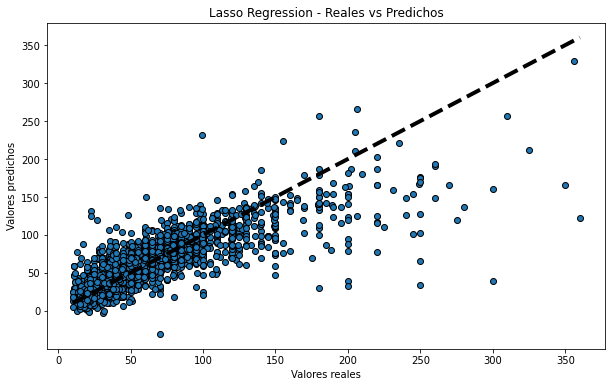

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Lasso Regression,758.642095,716.485685,27.543458,26.767250,0.618076,0.644140


In [73]:
# Validación cruzada 
alpha_vector = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_vector}
grid_lasso = GridSearchCV(Lasso(), param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2)
grid_lasso.fit(X_train_scaled, y_train)

# Mejor alpha encontrado
best_alpha = grid_lasso.best_params_['alpha']
best_lasso = Lasso(alpha=best_alpha)

best_lasso.fit(X_train_scaled, y_train)

coefs = pd.Series(best_lasso.coef_, index=feature_names)
selected_features_lasso = coefs[coefs != 0].index.tolist()

print("Características seleccionadas por Lasso:")
print(selected_features_lasso)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Filtramos las características seleccionadas en el conjunto de entrenamiento y prueba
X_train_selected_lasso = X_train.loc[:, selected_features_lasso]
X_test_selected_lasso = X_test.loc[:, selected_features_lasso]

X_train_imputed_selected = imputer.fit_transform(X_train_selected_lasso)
X_test_imputed_selected = imputer.transform(X_test_selected_lasso)
X_train_scaled_lasso = scaler.fit_transform(X_train_imputed_selected)
X_test_scaled_lasso = scaler.transform(X_test_imputed_selected)

# Evaluación con Lasso
results_lasso = []
results_lasso.append(evaluate_model(best_lasso, X_train_scaled_lasso, y_train, X_test_scaled_lasso, y_test, 'Lasso Regression'))
print_results_table(results_lasso, "Resultados de Lasso")


### 3.2.2 Random Forest: Validación cruzada y selección de características

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   4.2s
[CV] END ..max_depth=10, max_features=auto, n_es

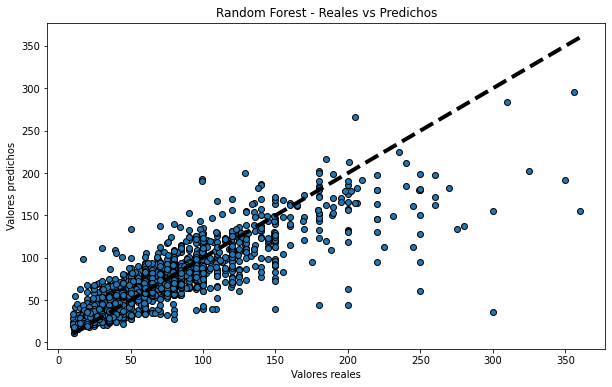

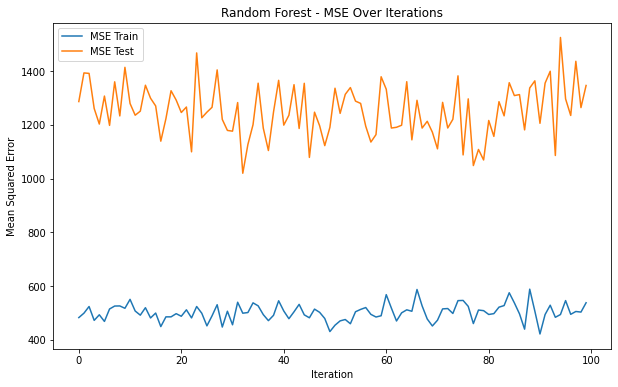

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Random Forest,94.000694,513.684574,9.695396,22.664611,0.952677,0.744866


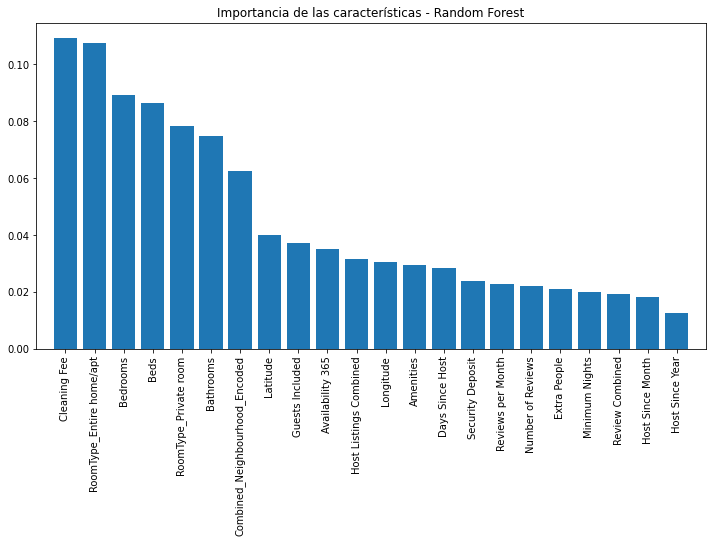

In [74]:
from sklearn.feature_selection import SelectFromModel

# Dejo estos parámetros tras varias pruebas de estimadores, profundidad...

param_grid_rf = {
    'n_estimators': [10, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
}

# Vaidación cruzada
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=10, scoring='neg_mean_squared_error', verbose=2)
grid_rf.fit(X_train_scaled, y_train)

# Mejor modelo 
best_rf = grid_rf.best_estimator_

# Seleccionamos las características importantes
selector_rf = SelectFromModel(best_rf, threshold='median', prefit=True)
X_train_rf_selected = selector_rf.transform(X_train_scaled)
X_test_rf_selected = selector_rf.transform(X_test_scaled)

selected_features_rf = feature_names[selector_rf.get_support()]

print("Características seleccionadas por Random Forest:")
print(selected_features_rf)

# Evaluación con Random Forest
results_rf = []
results_rf.append(evaluate_model(best_rf, X_train_rf_selected, y_train, X_test_rf_selected, y_test, 'Random Forest'))
print_results_table(results_rf, "Resultados de Random Forest")

# Importancia
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importancia de las características - Random Forest")
plt.bar(range(X_train_rf_selected.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_rf_selected.shape[1]), selected_features_rf[indices], rotation=90)
plt.xlim([-1, X_train_rf_selected.shape[1]])
plt.show()


### 3.2.3 XGBoost: Validación cruzada y selección de características

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] EN

[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total t

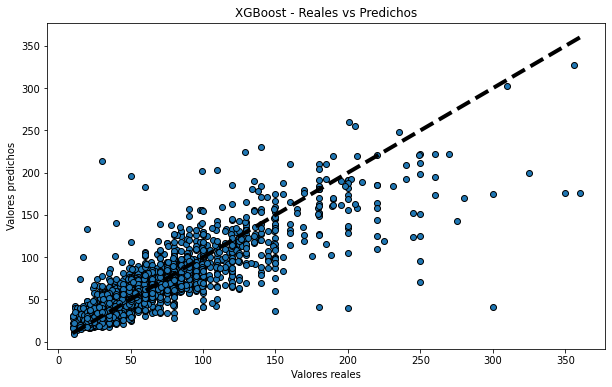

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
XGBoost,269.940409,539.327870,16.429863,23.223434,0.864104,0.732130


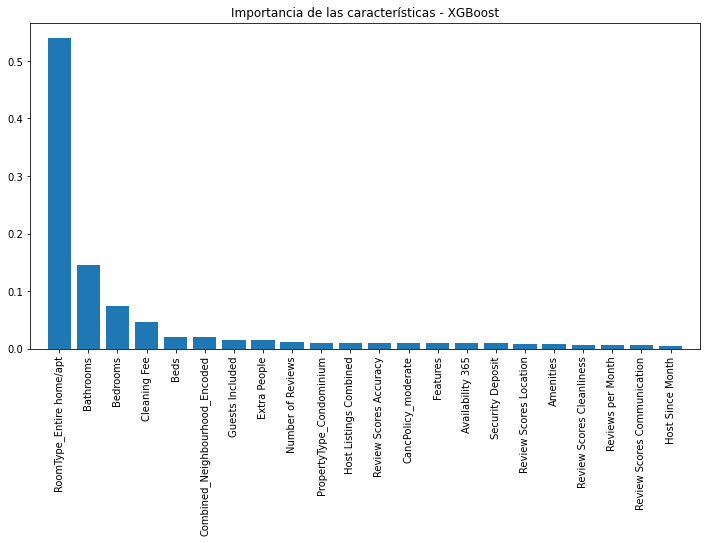

In [75]:
# Validación cruzada para encontrar los mejores hiperparámetros para XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}
grid_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=10, scoring='neg_mean_squared_error', verbose=2)
grid_xgb.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_xgb = grid_xgb.best_estimator_

# Seleccionar características importantes
selector_xgb = SelectFromModel(best_xgb, threshold='median', prefit=True)
X_train_xgb_selected = selector_xgb.transform(X_train_scaled)
X_test_xgb_selected = selector_xgb.transform(X_test_scaled)

# Obtener los nombres de las características seleccionadas
selected_features_xgb = feature_names[selector_xgb.get_support()]

print("Características seleccionadas por XGBoost:")
print(selected_features_xgb)

# Evaluación con XGBoost
results_xgb = []
results_xgb.append(evaluate_model(best_xgb, X_train_xgb_selected, y_train, X_test_xgb_selected, y_test, 'XGBoost'))
print_results_table(results_xgb, "Resultados de XGBoost")

# Importancia de características
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importancia de las características - XGBoost")
plt.bar(range(X_train_xgb_selected.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_xgb_selected.shape[1]), selected_features_xgb[indices], rotation=90)
plt.xlim([-1, X_train_xgb_selected.shape[1]])
plt.show()


In [76]:
# Muestra de todos los resultados con selección de características

all_results = results_lasso + results_rf + results_xgb
print_results_table(all_results, "Comparación de los modelos con selección de características")

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Lasso Regression,758.642095,716.485685,27.543458,26.767250,0.618076,0.644140
Random Forest,94.000694,513.684574,9.695396,22.664611,0.952677,0.744866
XGBoost,269.940409,539.327870,16.429863,23.223434,0.864104,0.732130


## 3.3 Evaluación de modelos con validación cruzada y todas las características: Lasso, Random Forest y XGBoost

### 3.3.1 Lasso: Validación cruzada y todas las características

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................................alpha=0.0001; total time=   0.2s
[CV] END .......................alpha=0.00012067926406393288; total time=   0.2s
[CV] END .......................alpha=0.000120

[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.3s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.3s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.3s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.3s
[CV] END ........................alpha=0.0006551285568595509; total time=   0.2s
[CV] END ........................alpha=0.0007906043210907702; total time=   0.2s
[CV] END ........................alpha=0.0007906043210907702; total time=   0.3s
[CV] END ........................alpha=0.0007906043210907702; total time=   0.2s
[CV] END ...................

[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.004291934260128779; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END .........................alpha=0.005179474679231213; total time=   0.0s
[CV] END ...................

[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END .........................alpha=0.040949150623804234; total time=   0.0s
[CV] END ..........................alpha=0.04941713361323833; total time=   0.0s
[CV] END ..........................alpha=0.04941713361323833; total time=   0.0s
[CV] END ...................

[CV] END ...........................alpha=0.2682695795279725; total time=   0.0s
[CV] END ...........................alpha=0.2682695795279725; total time=   0.0s
[CV] END ...........................alpha=0.2682695795279725; total time=   0.0s
[CV] END ...........................alpha=0.2682695795279725; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ..........................alpha=0.32374575428176433; total time=   0.0s
[CV] END ...................

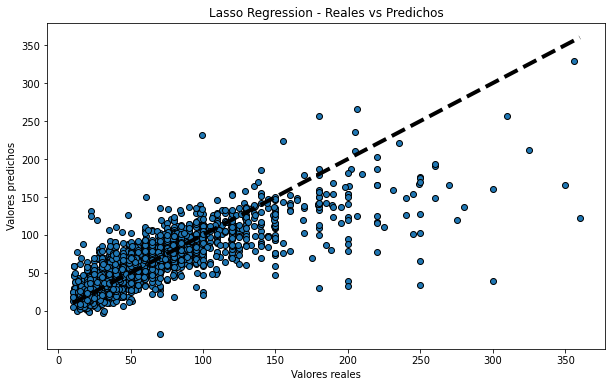

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Lasso Regression,758.642451,716.486168,27.543465,26.767259,0.618076,0.644140


In [77]:
# Validación cruzada 
alpha_vector = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_vector}
grid_lasso = GridSearchCV(Lasso(), param_grid=param_grid, cv=10, scoring='neg_mean_squared_error', verbose=2)
grid_lasso.fit(X_train_scaled, y_train)

# Mejor alpha encontrado
best_alpha = grid_lasso.best_params_['alpha']
best_lasso = Lasso(alpha=best_alpha)

results_lasso_todo = []
results_lasso_todo.append(evaluate_model(best_lasso, X_train_scaled, y_train, X_test_scaled, y_test, 'Lasso Regression'))
print_results_table(results_lasso_todo, "Resultados de Lasso")


### 3.3.2 Random Forest: Validación cruzada y todas las características

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.5s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ...max_depth=10, max_features=auto, n_estimators=10; total time=   0.4s
[CV] END ..max_depth=10, max_features=auto, n_estimators=100; total time=   3.6s
[CV] END ..max_depth=10, max_features=auto, n_es

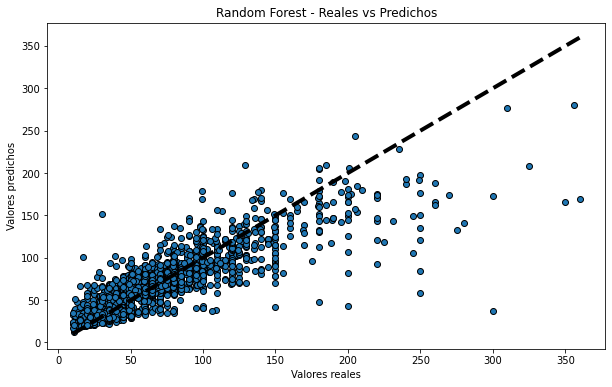

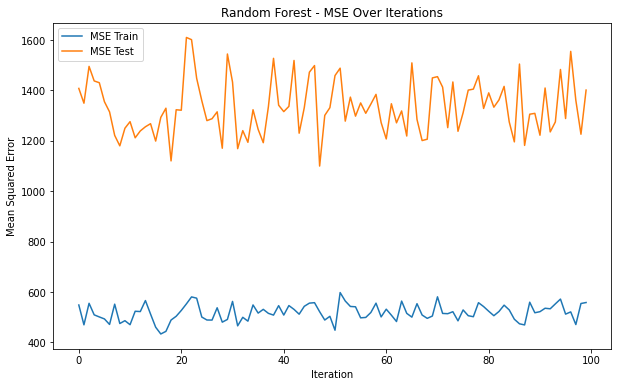

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Random Forest,96.058533,530.410671,9.800945,23.030646,0.951641,0.736559


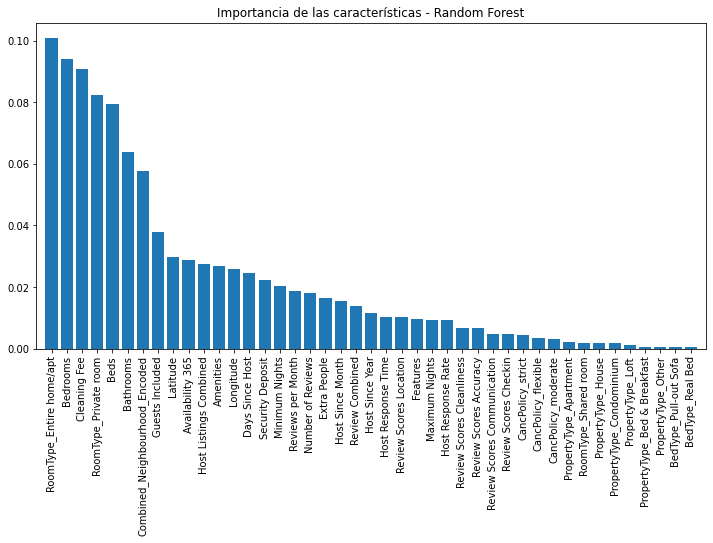

In [78]:
# Dejo estos parámetros tras varias pruebas de estimadores, profundidad...

param_grid_rf = {
    'n_estimators': [10, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20],
}

# Validación cruzada
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=10, scoring='neg_mean_squared_error', verbose=2)
grid_rf.fit(X_train_scaled, y_train)

# Mejor modelo 
best_rf = grid_rf.best_estimator_

results_rf_todo = []
results_rf_todo.append(evaluate_model(best_rf, X_train_scaled, y_train, X_test_scaled, y_test, 'Random Forest'))
print_results_table(results_rf_todo, "Resultados de Random Forest")

# Importancia 
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importancia de las características - Random Forest")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()


### 3.3.3 XGBoost: Validación cruzada y todas las características

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] EN

[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total t

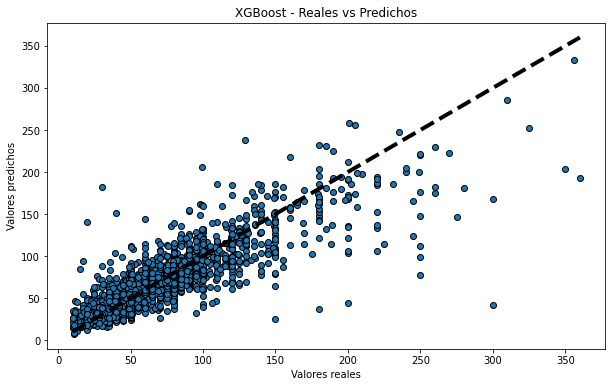

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
XGBoost,233.812361,502.278343,15.290924,22.411567,0.882292,0.750532


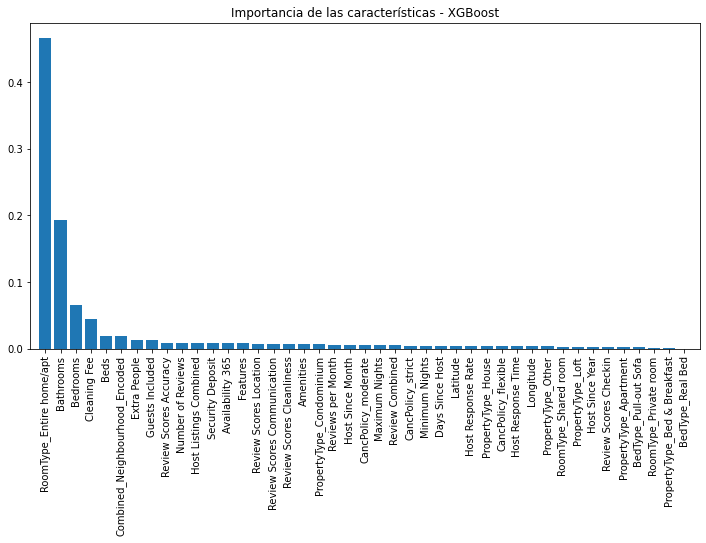

In [79]:
# Dejo estos parámetros tras varias pruebas de estimadores, profundidad...

param_grid_xgb = {
    'n_estimators': [50, 100],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
}

# Validación cruzada
grid_xgb = GridSearchCV(xgb.XGBRegressor(random_state=42), param_grid_xgb, cv=10, scoring='neg_mean_squared_error', verbose=2)
grid_xgb.fit(X_train_scaled, y_train)

# Mejor modelo 
best_xgb = grid_xgb.best_estimator_

results_xgb_todo = []
results_xgb_todo.append(evaluate_model(best_xgb, X_train_scaled, y_train, X_test_scaled, y_test, 'XGBoost'))
print_results_table(results_xgb_todo, "Resultados de XGBoost")

# Importancia
importances = best_xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Importancia de las características - XGBoost")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.show()


Una vez finalizados los análisis de todos los modelos, voy a ver los resultados de las dos opciones en una misma celda para analizar mejor la comparativa entre las tablas.

In [80]:
all_results_todo = results_lasso_todo + results_rf_todo + results_xgb_todo

print_results_table(all_results_todo, "Comparación de los modelos con todas las variables")
print_results_table(all_results, "Comparación de los modelos con selección de características")

,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Lasso Regression,758.642451,716.486168,27.543465,26.767259,0.618076,0.644140
Random Forest,96.058533,530.410671,9.800945,23.030646,0.951641,0.736559
XGBoost,233.812361,502.278343,15.290924,22.411567,0.882292,0.750532


,MSE Train,MSE Test,RMSE Train,RMSE Test,R2 Train,R2 Test
Model,,,,,,
Lasso Regression,758.642095,716.485685,27.543458,26.767250,0.618076,0.644140
Random Forest,94.000694,513.684574,9.695396,22.664611,0.952677,0.744866
XGBoost,269.940409,539.327870,16.429863,23.223434,0.864104,0.732130


Comprobamos, a priori, que el modelo que obtiene mejores resultados es Random Forest con selección de características o XGBoost con todas las variables, pero vamos a verlo en mayor profundidad en las conclusiones.

Otra opción también sería comparar cada método de selección de características con cada uno de los modelos Lasso, Random Forest y XGBoost, y ver la combinación más óptima, pero me parece que es computacionalmente muy costoso, por lo que he decidido hacer cada método con su modelo.

# 4. Conclusiones

Aquí voy a trasladar las conclusiones de todos los datos obtenidos.

1. Lasso no presenta diferencias significativas entre todas las variables y la selección de características, y, en comparación con los otros dos modelos, presenta el MSE y RMSE más alto y menor R2. Por lo que lo descartamos directamente.

2. Random Forest mejora ligeramente con la selección de características, donde consigue reducir los errores y mejora también el R2. Su R2 en general es alto, lo que puede reflejar un buen ajuste.

3. XGBoost es el único modelo que empeora sus resultados con la selección de características, teniendo mejor ajuste cuando tiene en cuenta todas las variables. Sus diferencias en cuanto a errores y accuracy, respecto a los datos de Random Forest, no son muy significativas.

Tanto Random Forest como XGBoost parecen buenos modelos que generalizan bien el conjunto de datos. Puede que tengan un ligero sobreajuste debido a la diferencia en los errores de Train y Test, pero, considerando el rango de valores, no parece ser algo especialmente relevante para la generalización.

Por ello, elijo quedarme con XGBoost, ya que parece generalizar bien, con buenos resultados, parece robusto y podemos considerar ajustes adicionales de sus hiperparámetros como futuros pasos.